In [2]:
# prompt: podłączenie dysku

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install xgboost

In [4]:
pip install imbalanced-learn


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from scipy.stats import spearmanr
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, roc_auc_score, f1_score, balanced_accuracy_score, matthews_corrcoef, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, ShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN
import shap
from sklearn.model_selection import learning_curve


Spis tereści  
5 [Modelowanie](#5)  
    5.1 [Wczytanie danych](#51)  
    5.2 [Przekształcenie wszystkich zmiennych na numeryczne](#52)  
    5.3 [Standaryzacja danych](#53)  
    5.3.1 [Wybór metody standaryzacji](#531)  
    5.3.1.1 [StandardScaler](#5311)  
    5.3.1.2 [Normalizacja](#5312)  
    5.3.1.3 [RobustSCaler](#5313)  
    5.3.1.4 [QuabtileTransformer](#5314)  
    5.3.2 [Zbiór do modelowania](#532)  
    5.4 [Modelowanie](#54)  
    5.4.1 [Definicje i zmienne](#541)  
    5.4.2 [Wybrane modele](#542)  
    5.4.3 [Trenowanie modeli na danych wyjściowych](#543)  
    5.4.4 [Skompresowanie danych PCA](#544)  
    5.4.4.1 [PCA zachowująca określony procent wariancji](#5441)  
    5.4.4.2 [PCA redukująca do okreslonej ilości zmiennych](#5442)  
    5.4.4.3 [Zbiór PCA](#5443)  
    5.4.4.4 [Ocena efektywności predykcji po PCA](#5444)  
    5.4.5 [Oversampling](#545)  
    5.4.5.1 [SMOTE](#5451)  
    5.4.5.1.1 [Przygotowanie danych](#54511)  
    5.4.5.1.2 [Trenowanie modeli](#54512)  
    5.4.5.2 [ADASYN](#5452)  
    5.4.5.2.1 [Przygotowanie danych](#54521)  
    5.4.5.2.2 [Trenowanie modeli](#54522)  
    5.5 [Dokładna analiza wybrranego modelu](#55)  
    5.5.1 [Dobór najlepszych parametrów](#551)  
    5.5.2 [Ensemble Learning](#552)  
    5.5.3 [Kros-walidacja](#553)  
    5.5.4 [Krzywa ROC](#554)  
    5.5.5 [Macierz konfuzji](#555)  
    5.5.6 [Kompromis między obciążeniem a wariancją](#556)  
    5.5.7 [Sprawdzenie istotnosci cech](#557)  
    5.5.7.1 [Współkorelacja](#5571)  
    5.5.7.2 [Rekurencyjna eliminacja cech](#5572)  
    5.5.7.2.1 [Model XGBC](#55721)  
    5.5.7.2.2 [Model LogisticRegression](#55722)  
    5.5.8 [Zmiana progu kwalifikacji](#558)  
    5.6 [Podsumowanie](#56)  

#### <a name = '5'></a> 5. Modelowanie

#### <a name = '5.1'></a> 5.1 Wczytanie danych

In [104]:
data_row = pd.read_csv('/content/drive/My Drive/Future_Collars/Loan_data_new_features.csv')


In [105]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [106]:
data = data_row.copy()


In [107]:
data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'pub_rec_bankruptcies', 'emp_length_num',
       'grade_num', 'fico_value', 'fico_category', 'term_numeric',
       'mths_since_last_record_new', 'annual_inc_log', 'annual_inc_cat',
       'earliest_cr_line_Y', 'loan_amnt_out', 'funded_amnt_out',
       'funded_amnt_inv_out', 'int_rate_out', 'annual_inc_out',
       'installment_trans', 'annual_inc_trans', 'inq_last_6mths_trans',
       'revol_bal_trans', 'funded_amnt_inv_out_trans', 'emp_length_bin',
       'pub_rec_bin', 'pub_rec_bankruptcies_bin', 'mths_since_last_

In [108]:
# Zmienne dobrane na zasadzie eliminacji - kryterium efekt na PCA. Ze zbioru usunięto zip_code ze względu na brak wpływy na wyniki uczenia.
# Po sprawdzeniu róznych kombinacji zmiennych i stwierdzeniu braku wpływu na wartości predykcji zmienne wybrane jako finalne do modelowania.
col_new_3 = ['loan_amnt_out', 'funded_amnt_out', 'funded_amnt_inv_out'
 , 'term', 'int_rate', 'installment_trans', 'grade_num', 'home_ownership',
             'verification_status', 'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths_trans',
  'open_acc', 'pub_rec_bin', 'revol_bal_trans', 'revol_util', 'total_acc', 'pub_rec_bankruptcies_bin',
 'fico_value', 'mths_since_last_record', 'annual_inc_cat',
  'emp_length_bin', 'mths_since_last_delinq_cat',
  'funded_to_loan_amnt_ratio',
 'funded_income_ratio', 'age_of_credit_lin', 'funded_inv_to_tot_ratio', 'mth_inc',
 'mth_install_to_incom', 'acc_hist','pub_rec_type', 'other_debt',
 'mth_debt_installment', 'fico_int_rate', 'funded_amnt_fico', 'dti_ratio_per_grade',
 'dti_ratio_per_purpose', 'mean_funded_addr_state', 'mean_annu_addr_state', 'mean_fico_addr_state',
 'desc_len', 'consolidation']


In [ ]:
# Zmienne pierwotne jak najmniej przetworzone + nowe
col_1new = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv',
 'term', 'int_rate', 'installment', 'grade','emp_length_bin',
 'home_ownership', 'verification_status', 'loan_status',
 'purpose', 'dti', 'mths_since_last_record_new', 'delinq_2yrs',
 'inq_last_6mths', 'open_acc', 'mths_since_last_delinq_cat',
 'pub_rec', 'annual_inc_out', 'revol_bal', 'revol_util', 'total_acc',
 'pub_rec_bankruptcies', 'fico_value', 'funded_to_loan_amnt_ratio',
 'funded_income_ratio', 'age_of_credit_lin', 'funded_inv_to_tot_ratio', 'mth_inc',
 'mth_install_to_incom', 'acc_hist','pub_rec_type', 'other_debt',
 'mth_debt_installment', 'fico_int_rate', 'funded_amnt_fico', 'dti_ratio_per_grade',
 'dti_ratio_per_purpose', 'mean_funded_addr_state', 'mean_annu_addr_state', 'mean_fico_addr_state',
 'desc_len', 'consolidation']



In [ ]:
# Zmienne pierwotne po przetworzeniu  - zostaje opcja najlepiej korelująca z 0_1_ratio + nowe skorelowane z 0_1_ratio
col_2new = [ 'loan_amnt_out', 'term', 'grade', 'zip_code', 'emp_length_bin', 'annual_inc_cat',
 'home_ownership',  'fico_value',
 'int_rate_out', 'mths_since_last_record_new', 'verification_status',
 'mths_since_last_delinq_cat', 'loan_status', 'installment_trans',
 'purpose', 'total_acc', 'delinq_2yrs', 'pub_rec_bin',
 'pub_rec_bankruptcies_bin', 'revol_util', 'revol_bal_trans', 'funded_amnt_inv_out_trans',
 'inq_last_6mths_trans', 'funded_income_ratio', 'age_of_credit_lin',
 'funded_inv_to_tot_ratio', 'acc_hist', 'pub_rec_type', 'mth_debt_installment',
 'fico_int_rate', 'funded_amnt_fico', 'dti_ratio_per_grade', 'mean_funded_addr_state',
 'mean_fico_addr_state']



#### <a name = '52'></a> 5.2 Przekształcenie wszystkich zmiennych na numeryczne

In [109]:
data = data[col_new_3]

In [110]:

data = pd.get_dummies(data, drop_first = True)

In [111]:
bool_columns = data.select_dtypes(include=['bool']).columns.tolist()
for col in bool_columns:
    data[col] = data[col].astype(int)

In [112]:
data.columns

Index(['loan_amnt_out', 'funded_amnt_out', 'funded_amnt_inv_out', 'int_rate',
       'installment_trans', 'grade_num', 'loan_status', 'dti', 'delinq_2yrs',
       'inq_last_6mths_trans', 'open_acc', 'pub_rec_bin', 'revol_bal_trans',
       'revol_util', 'total_acc', 'pub_rec_bankruptcies_bin', 'fico_value',
       'mths_since_last_record', 'emp_length_bin', 'funded_to_loan_amnt_ratio',
       'funded_income_ratio', 'age_of_credit_lin', 'funded_inv_to_tot_ratio',
       'mth_inc', 'mth_install_to_incom', 'acc_hist', 'other_debt',
       'mth_debt_installment', 'fico_int_rate', 'funded_amnt_fico',
       'dti_ratio_per_grade', 'dti_ratio_per_purpose',
       'mean_funded_addr_state', 'mean_annu_addr_state',
       'mean_fico_addr_state', 'desc_len', 'consolidation', 'term_ 60 months',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolid

In [113]:
data.shape

(42531, 65)

#### <a name = '53'></a> 5.3 Standaryzacja danych

In [114]:
X = data.drop(columns = 'loan_status', axis = 1)
y = data['loan_status']

In [115]:
# Podział danych na zbiór testowy i treningowy.
X_train_n, X_test_n, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [116]:
print(X_train_n.shape)
print(X_test_n.shape)
print(y_train.shape)
print(y_test.shape)

(34024, 64)
(8507, 64)
(34024,)
(8507,)


In [117]:
print(y_train[y_train == 0].count())
print(y_train[y_train == 1].count())
print(y_test[y_test == 0].count())
print(y_test[y_test == 1].count())

5103
28921
1328
7179


#### <a name = '531'></a> 5.3.1 Wybór metody standaryzacji

#### <a name = '5311'></a> 5.3.1.1 StandartScaler

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_n)
X_test = scaler.transform(X_test_n)

#### <a name = '5312'></a> 5.3.1.2 Normalizacja

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_n)
X_test = scaler.transform(X_test_n)

#### <a name = '5313'></a> 5.3.1.3 RobustScaler

In [118]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_n)
X_test = scaler.transform(X_test_n)

#### <a name = '5314'></a> 5.3.1.4 QuantileTransformer

In [ ]:
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
X_train = scaler.fit_transform(X_train_n)
X_test = scaler.transform(X_test_n)

#### <a name = '532'></a> 5.3.2 Zbiór do modelowania

In [119]:
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

#### <a name = '54'></a> 5.4 Modelowanie

#### <a name = '541'></a> 5.4.1 Definicje i zmienne

In [120]:
# Waga dla modelu ze względu na niezbalansowanie danych
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = {i: class_weights[i] for i in range(len(class_weights))}
weights[0] = weights[0]


In [121]:
# Wagi do modelu - inne podejście
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1) * 1

In [122]:
#Dodawanie wyników do tabeli
def add_to_results_table(model_name, roc_auc, table):
    new_row = {'Model': model_name, 'ROC-AUC': roc_auc}
    table = pd.concat([table, pd.DataFrame([new_row])], ignore_index=True)
    return table

In [123]:
#Trenowanie modelu
def modelowanie(model, X_train, y_train, X_test, y_test):

    model.fit(X_train, y_train)

    predictions_test = model.predict(X_test)
    probabilities_test = model.predict_proba(X_test)[:, 1]
    roc_auc_test = roc_auc_score(y_test, probabilities_test)

    predictions_train = model.predict(X_train)
    probabilities_train = model.predict_proba(X_train)[:, 1]
    roc_auc_train = roc_auc_score(y_train, probabilities_train)

    print("=== ZBIÓR TESTOWY ===")
    print(classification_report(y_test, predictions_test))
    print(f"ROC AUC (klasa 1): {roc_auc_test:.2f}")

    print("\n=== ZBIÓR TRENINGOWY ===")
    print(classification_report(y_train, predictions_train))
    print(f"ROC AUC (klasa 1): {roc_auc_train:.2f}")

Ze względu na problem z automatyczną optymalizacją hiperparametrów - długi okres, podczas uczenia  sprawdzono różne zakresy parametrów i ostatecznie pozostawiono te które dawały najlepsze metryki.  
Modele trenowane były na obserwacjach ze zbioru wyjsciowego z zastosowaniem wag (brak wag powodował bardzo słabe metryki dla targetu 0), na zbiorze po oversamplingu oraz PCA.

In [124]:
results= pd.DataFrame(columns=['Model', 'ROC-AUC'])

#### <a name = '542'></a> 5.4.2 Wybrane modele

Analizowany problem ma charakter klasyfikacyjny dlatego do trenowania wybrano nastepujące model:  
- LogisticRegression  
- RandomForestClassifier  
- KNeighborsClassifier  
- XGBClassifier  
- BaggingClassifier  
- AdaBoostClassifier  

#### <a name = '543'></a> 5.4.3 Trenowanie modeli na danych wyjściowych

In [125]:
model = LogisticRegression(solver = 'saga', max_iter=100, penalty='l2', class_weight=weights )
modelowanie(model, X_train, y_train, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.25      0.65      0.36      1328
           1       0.91      0.64      0.75      7179

    accuracy                           0.64      8507
   macro avg       0.58      0.65      0.56      8507
weighted avg       0.81      0.64      0.69      8507

ROC AUC (klasa 1): 0.70

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.25      0.68      0.36      5103
           1       0.92      0.64      0.75     28921

    accuracy                           0.64     34024
   macro avg       0.58      0.66      0.56     34024
weighted avg       0.82      0.64      0.69     34024

ROC AUC (klasa 1): 0.71


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [126]:
results = add_to_results_table('lr - waga', 0.70, results)

<ipython-input-122-72d50842022b>:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame([new_row])], ignore_index=True)


In [127]:
model2 = RandomForestClassifier(n_estimators=100, max_features = 'log2', min_samples_split=50, min_samples_leaf=10, max_depth=3,  class_weight=weights )
modelowanie(model2, X_train, y_train, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.22      0.68      0.34      1328
           1       0.90      0.56      0.69      7179

    accuracy                           0.58      8507
   macro avg       0.56      0.62      0.51      8507
weighted avg       0.80      0.58      0.64      8507

ROC AUC (klasa 1): 0.68

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.22      0.69      0.33      5103
           1       0.91      0.56      0.69     28921

    accuracy                           0.58     34024
   macro avg       0.56      0.63      0.51     34024
weighted avg       0.81      0.58      0.64     34024

ROC AUC (klasa 1): 0.69


In [128]:
results = add_to_results_table('rfc - - waga', 0.68, results)

In [129]:
model4 = KNeighborsClassifier(n_neighbors=15, weights='uniform', metric='cosine')# weights='uniform', distance' - przeuczenie, metric='manhattan', 'chebyshev', 'cosine'
modelowanie(model4, X_train, y_train, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.34      0.02      0.04      1328
           1       0.85      0.99      0.91      7179

    accuracy                           0.84      8507
   macro avg       0.59      0.51      0.48      8507
weighted avg       0.77      0.84      0.78      8507

ROC AUC (klasa 1): 0.63

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.61      0.05      0.09      5103
           1       0.86      0.99      0.92     28921

    accuracy                           0.85     34024
   macro avg       0.74      0.52      0.51     34024
weighted avg       0.82      0.85      0.80     34024

ROC AUC (klasa 1): 0.78


In [130]:
results = add_to_results_table('knn -waga', 0.63, results)

In [131]:
model5 = xgb.XGBClassifier(random_state=1, n_estimators = 250,  max_depth=5, learning_rate=0.01,  scale_pos_weight=scale_pos_weight)#Wprowadzenie regularyzacji alpha lub lambda nie pomogło
modelowanie(model5, X_train, y_train, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.25      0.65      0.37      1328
           1       0.91      0.65      0.75      7179

    accuracy                           0.65      8507
   macro avg       0.58      0.65      0.56      8507
weighted avg       0.81      0.65      0.69      8507

ROC AUC (klasa 1): 0.70

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.26      0.71      0.38      5103
           1       0.93      0.65      0.76     28921

    accuracy                           0.66     34024
   macro avg       0.59      0.68      0.57     34024
weighted avg       0.83      0.66      0.71     34024

ROC AUC (klasa 1): 0.75


In [132]:
results = add_to_results_table('xgb - waga', 0.70, results)

In [133]:
model6 = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5,class_weight=weights, min_samples_leaf=10, min_samples_split=10),  n_estimators=100, random_state=42)
modelowanie(model6, X_train, y_train, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.24      0.67      0.36      1328
           1       0.91      0.61      0.73      7179

    accuracy                           0.62      8507
   macro avg       0.58      0.64      0.54      8507
weighted avg       0.80      0.62      0.67      8507

ROC AUC (klasa 1): 0.69

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.24      0.69      0.36      5103
           1       0.92      0.61      0.74     28921

    accuracy                           0.62     34024
   macro avg       0.58      0.65      0.55     34024
weighted avg       0.82      0.62      0.68     34024

ROC AUC (klasa 1): 0.72


In [134]:
results = add_to_results_table('bagging - waga', 0.67, results)

In [135]:
model7 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,class_weight=weights,  min_samples_leaf=5, min_samples_split=10), n_estimators=100, learning_rate = 0.1, random_state=42)
modelowanie(model7, X_train, y_train, X_test, y_test)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.26      0.63      0.37      1328
           1       0.91      0.66      0.77      7179

    accuracy                           0.66      8507
   macro avg       0.58      0.65      0.57      8507
weighted avg       0.81      0.66      0.70      8507

ROC AUC (klasa 1): 0.70

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.27      0.70      0.39      5103
           1       0.93      0.67      0.77     28921

    accuracy                           0.67     34024
   macro avg       0.60      0.68      0.58     34024
weighted avg       0.83      0.67      0.72     34024

ROC AUC (klasa 1): 0.76


In [136]:
results = add_to_results_table('adaboost - waga', 0.7, results)

Podczas trenowania dla modeli BaggingClassifier i AdaBoostClassifier oprócz domyslnego estymatora - DecisionTreeClassifier zastosowano również LogisticRegression, zmiena nie przyniosła poprawy modelu

In [137]:
results

,Model,ROC-AUC
0,lr - waga,0.70
1,rfc - - waga,0.68
2,knn -waga,0.63
3,xgb - waga,0.70
4,bagging - waga,0.67
5,adaboost - waga,0.70


#### <a name = '544'></a> 5.4.4 Skompresowanie danych PCA

#### <a name = '5441'></a> 5.4.4.1 PCA zachowująca określony procent wariancji

In [138]:
# PCA zachowujące 98% wariancji
from sklearn.decomposition import PCA
pca_98 = PCA(n_components=0.98)
X_train_pca = pca_98.fit_transform(X_train)
X_test_pca = pca_98.transform(X_test)
print(f"Liczba komponentów do zachowania 98% wariancji: {pca_98.n_components_}")

Liczba komponentów do zachowania 98% wariancji: 2


In [139]:
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(pca_98.n_components_)])

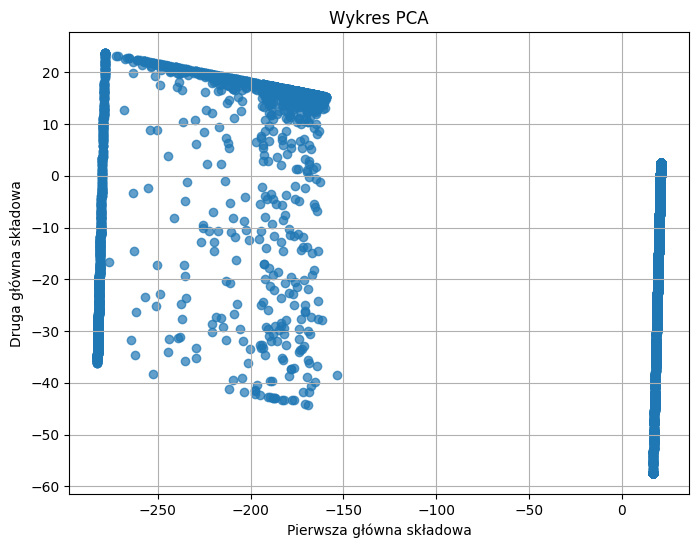

In [140]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.7)
plt.xlabel('Pierwsza główna składowa')
plt.ylabel('Druga główna składowa')
plt.title('Wykres PCA')
plt.grid(True)
plt.show()

In [141]:
components = pca_98.components_
feature_names = X.columns
df_components = pd.DataFrame(components, columns=feature_names, index=[f'Component {i+1}' for i in range(components.shape[0])])

In [142]:
# Wyjaśniona wariancja przez każdą z głównych składowych
print("Wyjaśniona wariancja przez składowe: ", pca_98.explained_variance_ratio_)

Wyjaśniona wariancja przez składowe:  [0.9734311  0.02215156]


In [143]:
df = round(df_components.T, 3)
df

,Component 1,Component 2
loan_amnt_out,0.001,-0.002
funded_amnt_out,0.001,-0.001
funded_amnt_inv_out,0.002,0.017
int_rate,-0.001,0.001
installment_trans,0.000,-0.004
grade_num,-0.001,-0.005
dti,0.000,0.001
delinq_2yrs,-0.000,-0.001
inq_last_6mths_trans,-0.001,-0.003
open_acc,-0.000,-0.002


In [144]:
# Wyjaśnienie składu zmiennych
df[(df>0.1) | (df<-0.1)].dropna(how = 'all', axis = 0)

,Component 1,Component 2
mths_since_last_record,0.997,NaN
funded_inv_to_tot_ratio,NaN,0.997


#### <a name = '5442'></a> 5.4.4.2 PCA redukująca do okreslonej ilości zmiennych

In [146]:
# PCA redukujące wymiar do 5 komponentów; svd_solver - nie ma wpływu
pca_5 = PCA(n_components=5)
X_train_pca = pca_5.fit_transform(X_train)
X_test_pca = pca_5.transform(X_test)

print(f"Sumaryczna wyjaśniona wariancja dla 5 komponentów: {sum(pca_5.explained_variance_ratio_)}")

Sumaryczna wyjaśniona wariancja dla 5 komponentów: 0.9978168585021363


In [147]:
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(pca_5.n_components_)])

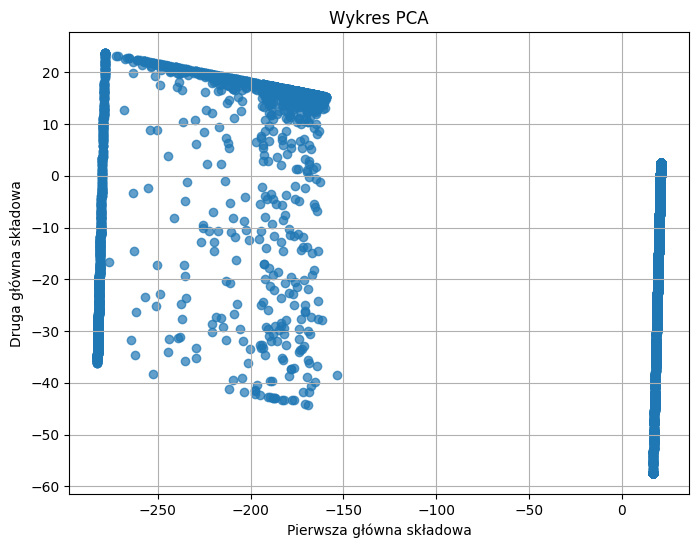

In [148]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.7)
plt.xlabel('Pierwsza główna składowa')
plt.ylabel('Druga główna składowa')
plt.title('Wykres PCA')
plt.grid(True)
plt.show()

In [149]:
components = pca_5.components_
feature_names = X.columns
df_components = pd.DataFrame(components, columns=feature_names, index=[f'Component {i+1}' for i in range(components.shape[0])])

In [150]:
# Wyjaśniona wariancja przez każdą z głównych składowych
print("Wyjaśniona wariancja przez składowe: ", pca_5.explained_variance_ratio_)

Wyjaśniona wariancja przez składowe:  [9.73431100e-01 2.21515561e-02 9.84832053e-04 6.67062529e-04
 5.82307652e-04]


In [151]:
df = round(df_components.T, 3)
df

,Component 1,Component 2,Component 3,Component 4,Component 5
loan_amnt_out,0.001,-0.002,0.249,-0.179,0.151
funded_amnt_out,0.001,-0.001,0.243,-0.176,0.142
funded_amnt_inv_out,0.002,0.017,0.248,-0.179,0.143
int_rate,-0.001,0.001,0.259,0.202,-0.095
installment_trans,0.000,-0.004,0.246,-0.203,0.126
grade_num,-0.001,-0.005,0.241,0.198,-0.089
dti,0.000,0.001,0.038,0.109,0.137
delinq_2yrs,-0.000,-0.001,0.018,0.042,-0.012
inq_last_6mths_trans,-0.001,-0.003,0.023,0.043,-0.007
open_acc,-0.000,-0.002,0.043,0.034,0.240


In [152]:
#Wyjaśnienie składu zmiennych
df[(df>0.1) | (df<-0.1)].dropna(how = 'all', axis = 0)

,Component 1,Component 2,Component 3,Component 4,Component 5
loan_amnt_out,NaN,NaN,0.249,-0.179,0.151
funded_amnt_out,NaN,NaN,0.243,-0.176,0.142
funded_amnt_inv_out,NaN,NaN,0.248,-0.179,0.143
int_rate,NaN,NaN,0.259,0.202,NaN
installment_trans,NaN,NaN,0.246,-0.203,0.126
grade_num,NaN,NaN,0.241,0.198,NaN
dti,NaN,NaN,NaN,0.109,0.137
open_acc,NaN,NaN,NaN,NaN,0.240
revol_bal_trans,NaN,NaN,0.129,NaN,0.295
revol_util,NaN,NaN,0.106,0.138,NaN


#### <a name = '5443'></a> 5.4.4.3 Zbiór PCA

In [153]:
# Do analizy wybrano zbiór z 5 zmiennymi
X_train_pca = pd.DataFrame(X_train_pca, columns=['PCA1', 'PCA2','PCA3', 'PCA4', 'PCA5' ])
X_test_pca = pd.DataFrame(X_test_pca, columns=['PCA1', 'PCA2','PCA3', 'PCA4', 'PCA5'])

#### <a name = '5444'></a> 5.4.4.4 Ocena efektywności predykcji po PCA

In [154]:
model = LogisticRegression(solver = 'saga', max_iter=100, penalty='l2', class_weight=weights )
modelowanie(model, X_train_pca, y_train, X_test_pca, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.22      0.66      0.33      1328
           1       0.90      0.58      0.70      7179

    accuracy                           0.59      8507
   macro avg       0.56      0.62      0.52      8507
weighted avg       0.80      0.59      0.65      8507

ROC AUC (klasa 1): 0.66

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.22      0.67      0.33      5103
           1       0.91      0.58      0.71     28921

    accuracy                           0.59     34024
   macro avg       0.56      0.63      0.52     34024
weighted avg       0.81      0.59      0.65     34024

ROC AUC (klasa 1): 0.67


In [156]:
results = add_to_results_table('Logistic Regression - PCA', 0.56, results)

In [157]:
model2 = RandomForestClassifier(n_estimators=100,  min_samples_split=10, min_samples_leaf=10, max_depth=3,  class_weight=weights )
modelowanie(model2, X_train_pca, y_train, X_test_pca, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.20      0.75      0.32      1328
           1       0.91      0.44      0.59      7179

    accuracy                           0.49      8507
   macro avg       0.55      0.60      0.45      8507
weighted avg       0.80      0.49      0.55      8507

ROC AUC (klasa 1): 0.65

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.20      0.78      0.31      5103
           1       0.92      0.44      0.59     28921

    accuracy                           0.49     34024
   macro avg       0.56      0.61      0.45     34024
weighted avg       0.81      0.49      0.55     34024

ROC AUC (klasa 1): 0.67


In [158]:
results = add_to_results_table('rfc - pca', 0.65, results)

In [159]:
model4 = KNeighborsClassifier(n_neighbors=15)
modelowanie(model4, X_train_pca, y_train, X_test_pca, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.37      0.02      0.04      1328
           1       0.85      0.99      0.91      7179

    accuracy                           0.84      8507
   macro avg       0.61      0.51      0.48      8507
weighted avg       0.77      0.84      0.78      8507

ROC AUC (klasa 1): 0.61

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.59      0.03      0.07      5103
           1       0.85      1.00      0.92     28921

    accuracy                           0.85     34024
   macro avg       0.72      0.52      0.49     34024
weighted avg       0.81      0.85      0.79     34024

ROC AUC (klasa 1): 0.76


In [160]:
results = add_to_results_table('knn-pca', 0.61, results)

In [161]:
model5 = xgb.XGBClassifier(random_state=1, n_estimators = 250,  max_depth=5, learning_rate=0.01, scale_pos_weight=scale_pos_weight)
modelowanie(model5, X_train_pca, y_train, X_test_pca, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.23      0.62      0.33      1328
           1       0.90      0.61      0.72      7179

    accuracy                           0.61      8507
   macro avg       0.56      0.61      0.53      8507
weighted avg       0.79      0.61      0.66      8507

ROC AUC (klasa 1): 0.67

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.23      0.68      0.35      5103
           1       0.92      0.61      0.73     28921

    accuracy                           0.62     34024
   macro avg       0.57      0.64      0.54     34024
weighted avg       0.81      0.62      0.67     34024

ROC AUC (klasa 1): 0.71


In [162]:
results = add_to_results_table('xgb - pca', 0.66, results)

In [163]:
model6 = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5,class_weight=weights, min_samples_leaf=10, min_samples_split=10),  n_estimators=100, random_state=42)
modelowanie(model6, X_train_pca, y_train, X_test_pca, y_test)


=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.23      0.62      0.33      1328
           1       0.90      0.61      0.73      7179

    accuracy                           0.61      8507
   macro avg       0.56      0.62      0.53      8507
weighted avg       0.79      0.61      0.66      8507

ROC AUC (klasa 1): 0.66

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.23      0.66      0.34      5103
           1       0.91      0.61      0.73     28921

    accuracy                           0.61     34024
   macro avg       0.57      0.63      0.53     34024
weighted avg       0.81      0.61      0.67     34024

ROC AUC (klasa 1): 0.69


In [164]:
results = add_to_results_table('bagging - pca', 0.66, results)

In [165]:
model7 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,class_weight=weights,  min_samples_leaf=5, min_samples_split=10), n_estimators=10, random_state=42)
modelowanie(model7, X_train_pca, y_train, X_test_pca, y_test)




/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.22      0.63      0.33      1328
           1       0.90      0.59      0.71      7179

    accuracy                           0.60      8507
   macro avg       0.56      0.61      0.52      8507
weighted avg       0.79      0.60      0.65      8507

ROC AUC (klasa 1): 0.65

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.22      0.67      0.34      5103
           1       0.91      0.59      0.72     28921

    accuracy                           0.60     34024
   macro avg       0.57      0.63      0.53     34024
weighted avg       0.81      0.60      0.66     34024

ROC AUC (klasa 1): 0.69


In [166]:
results = add_to_results_table('adaboost - pca', 0.65, results)

In [167]:
results

,Model,ROC-AUC
0,lr - waga,0.70
1,rfc - - waga,0.68
2,knn -waga,0.63
3,xgb - waga,0.70
4,bagging - waga,0.67
5,adaboost - waga,0.70
6,Logistic Regression - PCA,0.56
7,Logistic Regression - PCA,0.56
8,rfc - pca,0.65
9,knn-pca,0.61


#### <a name = '545'></a> 5.4.5 Oversampling

#### <a name = '5451'></a> 5.4.5.1 SMOTE

#### <a name = '54511'></a> 5.4.5.1.1 Przygotowanie danych

In [168]:
smote = SMOTE(random_state=42,sampling_strategy = 1 )
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#### <a name = '54512'></a> 5.4.5.1.2 Trenowanie modeli

In [169]:
model = LogisticRegression(solver = 'saga',C = 0.3, max_iter=200, penalty='l2')
modelowanie(model, X_train_resampled, y_train_resampled, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.25      0.65      0.36      1328
           1       0.91      0.64      0.75      7179

    accuracy                           0.64      8507
   macro avg       0.58      0.65      0.56      8507
weighted avg       0.81      0.64      0.69      8507

ROC AUC (klasa 1): 0.70

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.66      0.69      0.67     28921
           1       0.67      0.65      0.66     28921

    accuracy                           0.67     57842
   macro avg       0.67      0.67      0.67     57842
weighted avg       0.67      0.67      0.67     57842

ROC AUC (klasa 1): 0.73


In [170]:
results = add_to_results_table('Logistic Regression - over', 0.70, results)

In [171]:
model2 = RandomForestClassifier(n_estimators=200, max_features = 'log2',  min_samples_split=10, min_samples_leaf=25 , max_depth=5)
modelowanie(model2, X_train_resampled, y_train_resampled, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.25      0.53      0.34      1328
           1       0.89      0.71      0.79      7179

    accuracy                           0.68      8507
   macro avg       0.57      0.62      0.56      8507
weighted avg       0.79      0.68      0.72      8507

ROC AUC (klasa 1): 0.68

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     28921
           1       0.76      0.71      0.74     28921

    accuracy                           0.74     57842
   macro avg       0.74      0.74      0.74     57842
weighted avg       0.74      0.74      0.74     57842

ROC AUC (klasa 1): 0.85


In [172]:
results = add_to_results_table('rfc - over', 0.68, results)

In [173]:
model4 = KNeighborsClassifier(n_neighbors=25, weights='uniform', metric='cosine')
modelowanie(model4, X_train_resampled, y_train_resampled, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.21      0.70      0.32      1328
           1       0.90      0.50      0.64      7179

    accuracy                           0.53      8507
   macro avg       0.55      0.60      0.48      8507
weighted avg       0.79      0.53      0.59      8507

ROC AUC (klasa 1): 0.64

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.67      0.95      0.79     28921
           1       0.91      0.54      0.68     28921

    accuracy                           0.74     57842
   macro avg       0.79      0.74      0.73     57842
weighted avg       0.79      0.74      0.73     57842

ROC AUC (klasa 1): 0.88


In [174]:
results = add_to_results_table('knn-over', 0.64, results)

In [175]:
model5 = xgb.XGBClassifier(random_state=1, n_estimators = 500,  max_depth=3, learning_rate=0.001, min_samples_split=15, min_samples_leaf=25)
modelowanie(model5, X_train_resampled, y_train_resampled, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:22:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.25      0.42      0.31      1328
           1       0.88      0.77      0.82      7179

    accuracy                           0.71      8507
   macro avg       0.56      0.59      0.57      8507
weighted avg       0.78      0.71      0.74      8507

ROC AUC (klasa 1): 0.66

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.75      0.70      0.73     28921
           1       0.72      0.77      0.74     28921

    accuracy                           0.74     57842
   macro avg       0.74      0.74      0.74     57842
weighted avg       0.74      0.74      0.74     57842

ROC AUC (klasa 1): 0.83


In [176]:
results = add_to_results_table('xgb - over', 0.66, results)

In [177]:
model6 = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, min_samples_split=10), n_estimators=100, random_state=42) #Użycie jako estymatora LogisticRegression nie pomogło
modelowanie(model6, X_train_resampled, y_train_resampled, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.25      0.42      0.31      1328
           1       0.88      0.77      0.82      7179

    accuracy                           0.71      8507
   macro avg       0.56      0.59      0.57      8507
weighted avg       0.78      0.71      0.74      8507

ROC AUC (klasa 1): 0.65

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.74      0.67      0.71     28921
           1       0.70      0.77      0.73     28921

    accuracy                           0.72     57842
   macro avg       0.72      0.72      0.72     57842
weighted avg       0.72      0.72      0.72     57842

ROC AUC (klasa 1): 0.78


In [178]:
results = add_to_results_table('bagging - over', 0.64, results)

In [179]:
model7 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,  min_samples_leaf=25, min_samples_split=25), n_estimators=100, random_state=42)
modelowanie(model7, X_train_resampled, y_train_resampled, X_test, y_test)




/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.36      0.12      0.18      1328
           1       0.86      0.96      0.90      7179

    accuracy                           0.83      8507
   macro avg       0.61      0.54      0.54      8507
weighted avg       0.78      0.83      0.79      8507

ROC AUC (klasa 1): 0.66

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     28921
           1       0.87      0.98      0.92     28921

    accuracy                           0.91     57842
   macro avg       0.92      0.91      0.91     57842
weighted avg       0.92      0.91      0.91     57842

ROC AUC (klasa 1): 0.97


In [180]:
results = add_to_results_table('adaboost - over', 0.65, results)

In [181]:
results

,Model,ROC-AUC
0,lr - waga,0.70
1,rfc - - waga,0.68
2,knn -waga,0.63
3,xgb - waga,0.70
4,bagging - waga,0.67
5,adaboost - waga,0.70
6,Logistic Regression - PCA,0.56
7,Logistic Regression - PCA,0.56
8,rfc - pca,0.65
9,knn-pca,0.61


#### <a name = '5452'></a> 5.4.5.2 ADASYN

#### <a name = '54521'></a> 5.4.5.2.1 Przygotowanie danych

In [182]:
adasyn = ADASYN(sampling_strategy=1.0, random_state=42)
X_train_a, y_train_a = adasyn.fit_resample(X_train, y_train)

#### <a name = '54522'></a> 5.4.5.2.2 Trenowanie modeli

In [183]:
model = LogisticRegression(solver = 'saga',C = 0.3, max_iter=200, penalty='l2')
modelowanie(model, X_train_a, y_train_a, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.24      0.68      0.36      1328
           1       0.91      0.61      0.73      7179

    accuracy                           0.62      8507
   macro avg       0.58      0.64      0.55      8507
weighted avg       0.81      0.62      0.67      8507

ROC AUC (klasa 1): 0.70

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.66      0.70      0.68     30137
           1       0.66      0.62      0.64     28921

    accuracy                           0.66     59058
   macro avg       0.66      0.66      0.66     59058
weighted avg       0.66      0.66      0.66     59058

ROC AUC (klasa 1): 0.71


In [184]:
results = add_to_results_table('Logistic Regression - adasyn', 0.70, results)

In [185]:
model2 = RandomForestClassifier(n_estimators=200, max_features = 'log2',  min_samples_split=10, min_samples_leaf=25 , max_depth=5)
modelowanie(model2, X_train_a, y_train_a, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.24      0.53      0.33      1328
           1       0.89      0.70      0.78      7179

    accuracy                           0.67      8507
   macro avg       0.57      0.61      0.56      8507
weighted avg       0.79      0.67      0.71      8507

ROC AUC (klasa 1): 0.68

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.74      0.80      0.76     30137
           1       0.77      0.70      0.73     28921

    accuracy                           0.75     59058
   macro avg       0.75      0.75      0.75     59058
weighted avg       0.75      0.75      0.75     59058

ROC AUC (klasa 1): 0.86


In [186]:
results = add_to_results_table('rfc - adasyn', 0.68, results)

In [187]:
model4 = KNeighborsClassifier(n_neighbors=25, weights='uniform', metric='cosine')
modelowanie(model4, X_train_a, y_train_a, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.20      0.72      0.32      1328
           1       0.90      0.47      0.62      7179

    accuracy                           0.51      8507
   macro avg       0.55      0.60      0.47      8507
weighted avg       0.79      0.51      0.57      8507

ROC AUC (klasa 1): 0.63

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.67      0.96      0.79     30137
           1       0.93      0.50      0.65     28921

    accuracy                           0.74     59058
   macro avg       0.80      0.73      0.72     59058
weighted avg       0.80      0.74      0.72     59058

ROC AUC (klasa 1): 0.89


In [188]:
results = add_to_results_table('knn-adasyn', 0.63, results)

In [189]:
model5 = xgb.XGBClassifier(random_state=1, n_estimators = 500,  max_depth=3, learning_rate=0.001, min_samples_split=15, min_samples_leaf=25)
modelowanie(model5, X_train_a, y_train_a, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:28:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.25      0.42      0.31      1328
           1       0.88      0.77      0.82      7179

    accuracy                           0.71      8507
   macro avg       0.56      0.59      0.57      8507
weighted avg       0.78      0.71      0.74      8507

ROC AUC (klasa 1): 0.66

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.76      0.73      0.74     30137
           1       0.73      0.77      0.75     28921

    accuracy                           0.75     59058
   macro avg       0.75      0.75      0.75     59058
weighted avg       0.75      0.75      0.75     59058

ROC AUC (klasa 1): 0.83


In [190]:
results = add_to_results_table('xgb - adasyn', 0.66, results)

In [191]:
model6 = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, min_samples_split=10), n_estimators=100, random_state=42) #Użycie jako estymatora LogisticRegression nie pomogło
modelowanie(model6, X_train_a, y_train_a, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.25      0.42      0.31      1328
           1       0.88      0.77      0.82      7179

    accuracy                           0.71      8507
   macro avg       0.56      0.59      0.57      8507
weighted avg       0.78      0.71      0.74      8507

ROC AUC (klasa 1): 0.64

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.75      0.66      0.70     30137
           1       0.69      0.77      0.72     28921

    accuracy                           0.71     59058
   macro avg       0.72      0.72      0.71     59058
weighted avg       0.72      0.71      0.71     59058

ROC AUC (klasa 1): 0.76


In [192]:
results = add_to_results_table('bagging - adasyn', 0.64, results)

In [193]:
model7 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,  min_samples_leaf=25, min_samples_split=25), n_estimators=100, random_state=42)
modelowanie(model7, X_train_a, y_train_a, X_test, y_test)




/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.37      0.11      0.16      1328
           1       0.85      0.97      0.91      7179

    accuracy                           0.83      8507
   macro avg       0.61      0.54      0.54      8507
weighted avg       0.78      0.83      0.79      8507

ROC AUC (klasa 1): 0.66

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.98      0.86      0.91     30137
           1       0.87      0.98      0.92     28921

    accuracy                           0.92     59058
   macro avg       0.92      0.92      0.92     59058
weighted avg       0.92      0.92      0.92     59058

ROC AUC (klasa 1): 0.97


In [194]:
results = add_to_results_table('adaboost - adasyn', 0.66, results)

In [195]:
results

,Model,ROC-AUC
0,lr - waga,0.70
1,rfc - - waga,0.68
2,knn -waga,0.63
3,xgb - waga,0.70
4,bagging - waga,0.67
5,adaboost - waga,0.70
6,Logistic Regression - PCA,0.56
7,Logistic Regression - PCA,0.56
8,rfc - pca,0.65
9,knn-pca,0.61


Zastosowanie techniki oversamplingu ADASTN nie poprawiło wyników predykcji

#### <a name = '55'></a> 5.5 Dokładna anliza wybranego modelu.

Wszystkie modele posiadały bardzo zbliżone wartości ROCAU score ale podczas wyboru zwracano uwagę na metryki targetu 0. Jako finalny model po tym etapie wybrana została regresja logistyczna lub XGBClassifier - w zależności od wyników kolejnych testów. Modele te dały stosunkowo wysokie wartości metryk dla predykcji 0 i nie były zbyt przeuczone.

#### <a name = '551'></a> 5.5.1 Dobór najlepszych parametrów

In [ ]:
# Wybór nalepszych parametrów modelu:
param_grid = {
    'C': [0.01, 0.1, 0.4, 1, 2],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'penalty': ['l2', 'none']
}
grid_search = GridSearchCV(estimator = LogisticRegression(class_weight=weights), param_grid = param_grid,  cv=5, verbose=1, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.71


In [196]:
model = LogisticRegression(class_weight=weights, C= 0.1, solver= 'liblinear', penalty='l2')
modelowanie(model, X_train, y_train, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.25      0.64      0.36      1328
           1       0.91      0.65      0.75      7179

    accuracy                           0.65      8507
   macro avg       0.58      0.64      0.56      8507
weighted avg       0.80      0.65      0.69      8507

ROC AUC (klasa 1): 0.70

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.25      0.67      0.37      5103
           1       0.92      0.65      0.76     28921

    accuracy                           0.65     34024
   macro avg       0.58      0.66      0.56     34024
weighted avg       0.82      0.65      0.70     34024

ROC AUC (klasa 1): 0.72


In [ ]:
# Wybór nalepszych parametrów modelu na danych po oversamplingu:
param_grid = {
    'C': np.logspace(-4, 4, 10),
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'penalty': ['l2', 'none']  # l1 jest dostępne tylko dla solvera liblinear
}
grid_search = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid,  cv=5, verbose=0, scoring='roc_auc')
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters: {'C': 0.3593813663804626, 'penalty': 'l2', 'solver': 'newton-cg'}
Best cross-validation score: 0.72


In [197]:
model = LogisticRegression( C= 0.36, penalty='l2', solver= 'newton-cg' )
modelowanie(model, X_train_resampled, y_train_resampled, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.25      0.64      0.36      1328
           1       0.91      0.64      0.75      7179

    accuracy                           0.64      8507
   macro avg       0.58      0.64      0.56      8507
weighted avg       0.80      0.64      0.69      8507

ROC AUC (klasa 1): 0.70

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.66      0.69      0.67     28921
           1       0.67      0.65      0.66     28921

    accuracy                           0.67     57842
   macro avg       0.67      0.67      0.67     57842
weighted avg       0.67      0.67      0.67     57842

ROC AUC (klasa 1): 0.73


In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100]}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=1, scale_pos_weight=scale_pos_weight),
    param_grid=param_grid, scoring='roc_auc', cv=5, verbose=0)
grid_search.fit(X_train, y_train)

print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik ROC-AUC:", grid_search.best_score_)

Najlepsze parametry: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6}
Najlepszy wynik ROC-AUC: 0.7169523638528416


In [198]:
model5 = xgb.XGBClassifier(random_state=1,  colsample_bytree= 0.8, subsample =0.6, gamma= 0.1, learning_rate= 0.1, max_depth=3, min_child_weight= 5, n_estimators= 100, scale_pos_weight=scale_pos_weight)
modelowanie(model5, X_train, y_train, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.26      0.65      0.37      1328
           1       0.91      0.66      0.76      7179

    accuracy                           0.66      8507
   macro avg       0.58      0.65      0.57      8507
weighted avg       0.81      0.66      0.70      8507

ROC AUC (klasa 1): 0.71

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.27      0.70      0.38      5103
           1       0.92      0.66      0.77     28921

    accuracy                           0.67     34024
   macro avg       0.60      0.68      0.58     34024
weighted avg       0.83      0.67      0.71     34024

ROC AUC (klasa 1): 0.75


In [ ]:
param_grid = {
    'max_depth': [3, 5],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100]}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=1, scale_pos_weight=scale_pos_weight),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1)
grid_search.fit(X_train, y_train)

print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik ROC-AUC:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x78af35d22260>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 637, in _next_wrapper
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 550, in _handle_exception
    return fn()
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 1388, in next
    input_data(**self.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 617, in input_data
    new, cat_codes, feature_names, feature_types = _proxy

Najlepsze parametry: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100}
Najlepszy wynik ROC-AUC: 0.7151718840558342


In [199]:
model5 = xgb.XGBClassifier(random_state=1,  gamma= 0, learning_rate= 0.2, max_depth=3, min_child_weight= 5, n_estimators= 100, scale_pos_weight=scale_pos_weight)
modelowanie(model5, X_train, y_train, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.26      0.63      0.37      1328
           1       0.91      0.67      0.77      7179

    accuracy                           0.67      8507
   macro avg       0.59      0.65      0.57      8507
weighted avg       0.81      0.67      0.71      8507

ROC AUC (klasa 1): 0.71

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.28      0.71      0.40      5103
           1       0.93      0.68      0.79     28921

    accuracy                           0.69     34024
   macro avg       0.61      0.70      0.60     34024
weighted avg       0.83      0.69      0.73     34024

ROC AUC (klasa 1): 0.77


Trenowanie na optymalnych hiperparametrach nie poprawiło predykcji

#### <a name = '552'></a> 5.5.2 Ensemble Learning

In [200]:
# Ensemble Learning

base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, max_features = 'log2', min_samples_split=50, min_samples_leaf=10, max_depth=3,  class_weight=weights )),
    ('xgb', xgb.XGBClassifier(random_state=1,  colsample_bytree= 0.6,subsample =0.6,   gamma= 0.5, learning_rate= 0.2, max_depth=3, min_child_weight= 5, n_estimators= 200, scale_pos_weight=scale_pos_weight)),
    ('lr', LogisticRegression(solver = 'saga', max_iter=100, penalty='l2', class_weight=weights ))]

meta_model = LogisticRegression(random_state=42, solver='liblinear')

stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1)

stacking_model.fit(X_train_resampled, y_train_resampled)

y_pred = stacking_model.predict(X_test)
y_proba = stacking_model.predict_proba(X_test)[:, 1]

print("=== ZBIÓR TESTOWY ===")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")


=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.28      0.53      0.36      1328
           1       0.90      0.74      0.81      7179

    accuracy                           0.71      8507
   macro avg       0.59      0.64      0.59      8507
weighted avg       0.80      0.71      0.74      8507

ROC AUC: 0.7024


#### <a name = '553'></a> 5.5.3 Kros-walidacja

In [201]:
model = LogisticRegression(solver = 'saga', C = 0.1,  max_iter=100, penalty='l2', class_weight=weights)
#model = xgb.XGBClassifier(random_state=1,  colsample_bytree= 0.6,subsample =0.6,   gamma= 0.5, learning_rate= 0.2, max_depth=3, min_child_weight= 5, n_estimators= 200, scale_pos_weight=scale_pos_weight)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

# Wyświetlenie wyników
print("Wyniki kroswalidacji:", scores)
print("Średnia skuteczność:", scores.mean())
print("Wariancja wyników: ", np.var(scores))
print("Odchylenie standardowe wyników: ", np.std(scores))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Wyniki kroswalidacji: [0.64731815 0.64584864 0.64335048 0.63570904 0.6313933 ]
Średnia skuteczność: 0.6407239204496123
Wariancja wyników:  3.777099361869061e-05
Odchylenie standardowe wyników:  0.006145811062723178


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Kroswalidacja wykazała że model jest stabilny

Kroswalidacja modelu xgb.XGBClassifier:  
Wyniki kroswalidacji: [0.67817781 0.67817781 0.67450404 0.67714916 0.66402116]  
Średnia skuteczność: 0.6744059962134907  
Wariancja wyników:  2.8766487560323995e-05  
Odchylenie standardowe wyników:  0.005363439899945183  
Kroswalidacja modelu LogisticRegression:  
Wyniki kroswalidacji: [0.64761205 0.64540779 0.64349743 0.63556209 0.63154027]  
Średnia skuteczność: 0.640723924769153  
Wariancja wyników:  3.761224971445665e-05  
Odchylenie standardowe wyników:  0.006132882659439739  
  
  
Oba modele są stabilne ale model XGBoost wykazał większą stabilność i lepsze wyniki w porównaniu z regresją logistyczną, co sugeruje, że może być bardziej odpowiedni.

#### <a name = '554'></a> 5.5.4 Krzywa ROC

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


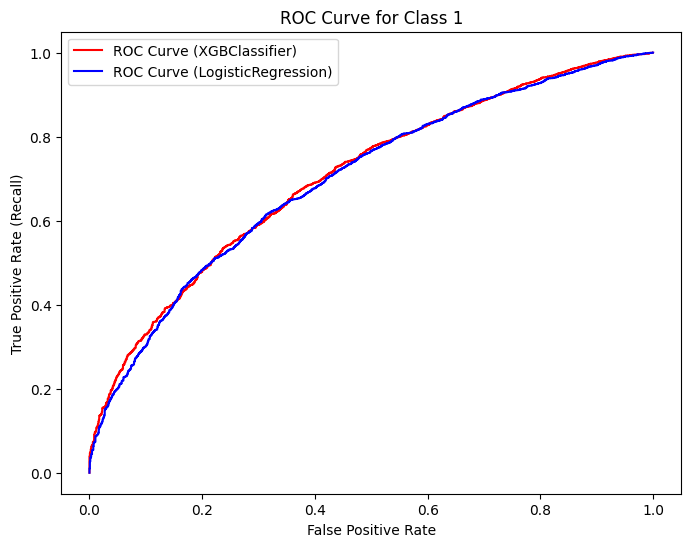

In [202]:
model = xgb.XGBClassifier(random_state=1,  colsample_bytree= 0.6,subsample =0.6,   gamma= 0.5, learning_rate= 0.2, max_depth=3, min_child_weight= 5, n_estimators= 200, scale_pos_weight=scale_pos_weight)
model1 = LogisticRegression(solver = 'saga', C = 0.1,  max_iter=100, penalty='l2', class_weight=weights)
model.fit(X_train, y_train)
model1.fit(X_train, y_train)
y_scores_class_1 = model.predict_proba(X_test)[:, 1]
y_scores_class_11 = model1.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores_class_1, pos_label=1)
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_scores_class_11, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (XGBClassifier)', color = 'red')
plt.plot(fpr1, tpr1, label='ROC Curve (LogisticRegression)', color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Class 1')
plt.legend()
plt.show()


#### <a name = '555'></a> 5.5.5 Macierz konfuzji

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


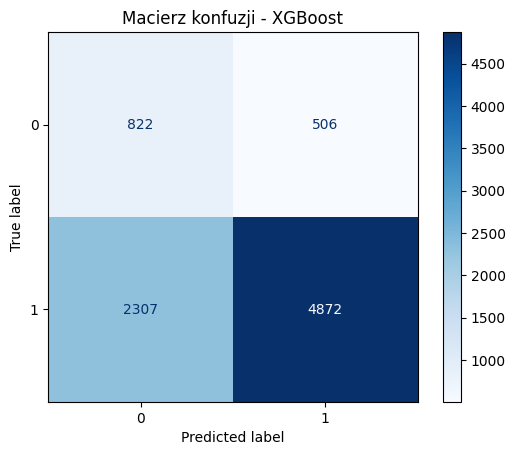

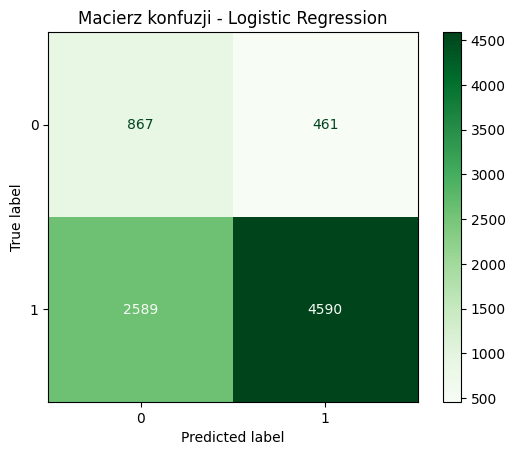

In [203]:
model = xgb.XGBClassifier(random_state=1,  colsample_bytree= 0.6,subsample =0.6,   gamma= 0.5, learning_rate= 0.2, max_depth=3, min_child_weight= 5, n_estimators= 200, scale_pos_weight=scale_pos_weight)
model1 = LogisticRegression(solver = 'saga', C = 0.1,  max_iter=100, penalty='l2', class_weight=weights)
model.fit(X_train, y_train)
model1.fit(X_train, y_train)

y_pred_xgb = model.predict(X_test)
y_pred_lr = model1.predict(X_test)

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=model.classes_)
disp_xgb.plot(cmap="Blues")
plt.title("Macierz konfuzji - XGBoost")
plt.show()

disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=model1.classes_)
disp_lr.plot(cmap="Greens")
plt.title("Macierz konfuzji - Logistic Regression")
plt.show()


Logistic Regression nieznacznie lepiej rozpoznaje klasę 0 (rzadziej klasyfikuje 0 jako 1).  
XGBoost lepiej rozpoznaje klasę 1 (rzadziej klasyfikuje 1 jako 0).  
Logistic Regression częściej klasyfikuje próbki klasy 1 jako 0, co wskazuje na gorszą skuteczność dla klasy 1 w porównaniu do XGBoost.  

#### <a name = '556'></a> 5.5.6 Kompromis miedzy obciążeniem a wariancją

In [204]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    scoring : str, callable, or None
        A string or callable to evaluate the predictions on the test set.
        Default is None.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


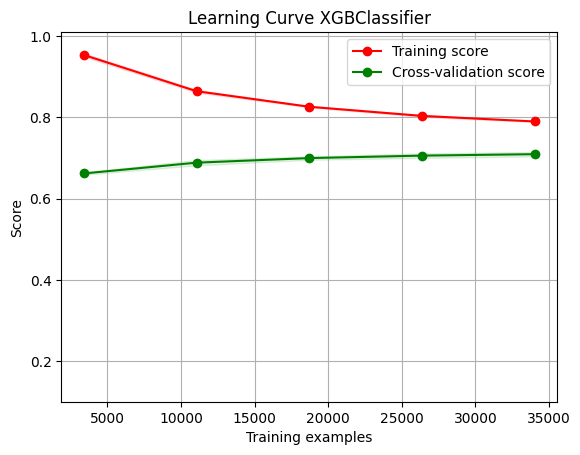

In [205]:
# Learning_curve na parametrach wytrenowanych dla XGBC
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(random_state=1,  colsample_bytree= 0.6,subsample =0.6,   gamma= 0.5, learning_rate= 0.2,
                          max_depth=3, min_child_weight= 5, n_estimators= 200, scale_pos_weight=scale_pos_weight)

plot_learning_curve(model, 'Learning Curve XGBClassifier', X, y, (0.1, 1.01), cv=cv, n_jobs=4, scoring='roc_auc')

plt.show()


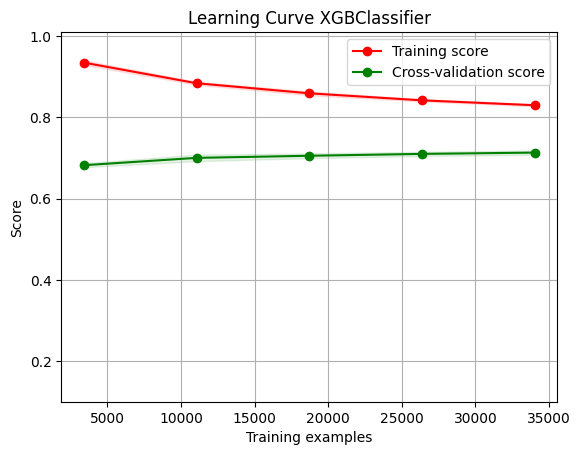

In [206]:
# Learning_curve XGBC - parametry zmodyfikowane w celu zmniejszenia luki pomiędzy krzywymi.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(random_state=1, colsample_bytree=1, subsample=1, gamma=0.5,
                          learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500,
                          scale_pos_weight=scale_pos_weight)

plot_learning_curve(model, 'Learning Curve XGBClassifier', X, y, (0.1, 1.01), cv=cv, n_jobs=4, scoring='roc_auc')

plt.show()

Brak wpływu optymalizacji parametrów na krzywe - jedynie training scor mniej sie zbiegała z cross-validation score

In [207]:
model = xgb.XGBClassifier(random_state=1, colsample_bytree=1, subsample=1, gamma=0.5,
                          learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500,
                          scale_pos_weight=scale_pos_weight)
modelowanie(model, X_train_resampled, y_train_resampled, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.25      0.67      0.37      1328
           1       0.91      0.64      0.75      7179

    accuracy                           0.64      8507
   macro avg       0.58      0.65      0.56      8507
weighted avg       0.81      0.64      0.69      8507

ROC AUC (klasa 1): 0.70

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.75      0.97      0.84     28921
           1       0.96      0.67      0.79     28921

    accuracy                           0.82     57842
   macro avg       0.85      0.82      0.82     57842
weighted avg       0.85      0.82      0.82     57842

ROC AUC (klasa 1): 0.97


Model jest przeuczony na zoptymalizowanych podczas learning_curve parametrach, a wartości predykcji zostają dalej takie same.

In [208]:
#Zastosowanie dla próbek po oversamplingu niczego nie poprawia, poza przeuczeniem modelu.
model = xgb.XGBClassifier(random_state=1, colsample_bytree=1, subsample=1, gamma=0.5,
                          learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=500)
modelowanie(model, X_train_resampled, y_train_resampled, X_test, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.48      0.04      0.08      1328
           1       0.85      0.99      0.91      7179

    accuracy                           0.84      8507
   macro avg       0.67      0.52      0.50      8507
weighted avg       0.79      0.84      0.78      8507

ROC AUC (klasa 1): 0.70

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     28921
           1       0.86      1.00      0.93     28921

    accuracy                           0.92     57842
   macro avg       0.93      0.92      0.92     57842
weighted avg       0.93      0.92      0.92     57842

ROC AUC (klasa 1): 0.97


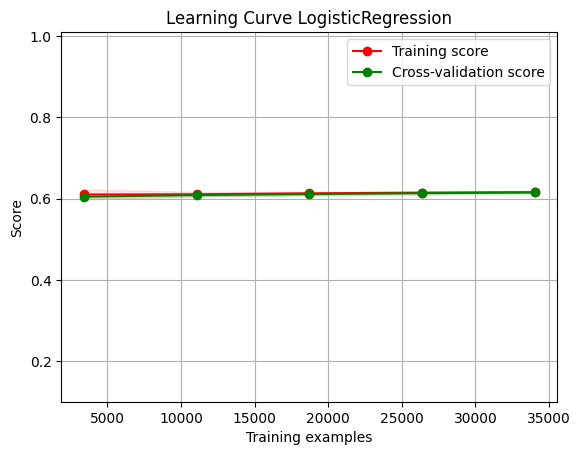

In [209]:
# Learning_curve dla LogisticRegression
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

model = LogisticRegression(solver = 'saga',penalty='l2',  C = 1,  max_iter=200,  class_weight=weights)


plot_learning_curve(model, 'Learning Curve LogisticRegression', X, y, (0.1, 1.01), cv=cv, n_jobs=4, scoring='roc_auc')


plt.show()


#### <a name = '557'></a> 5.5.7 Sprawdzenie istotności cech

Ranking istotnych cech:
                                Feature  Importance
5                             grade_num    0.111032
29                  dti_ratio_per_grade    0.090095
36                      term_ 60 months    0.043829
27                        fico_int_rate    0.037236
52               purpose_small_business    0.034886
3                              int_rate    0.029433
58                annual_inc_cat_low-Q1    0.027745
8                  inq_last_6mths_trans    0.027486
17                       emp_length_bin    0.021355
22                              mth_inc    0.021076
21              funded_inv_to_tot_ratio    0.020108
16               mths_since_last_record    0.019801
42                  purpose_credit_card    0.018387
30                dti_ratio_per_purpose    0.016023
2                   funded_amnt_inv_out    0.014910
19                  funded_income_ratio    0.014485
47               purpose_major_purchase    0.014295
33                 mean_fico_addr_state 

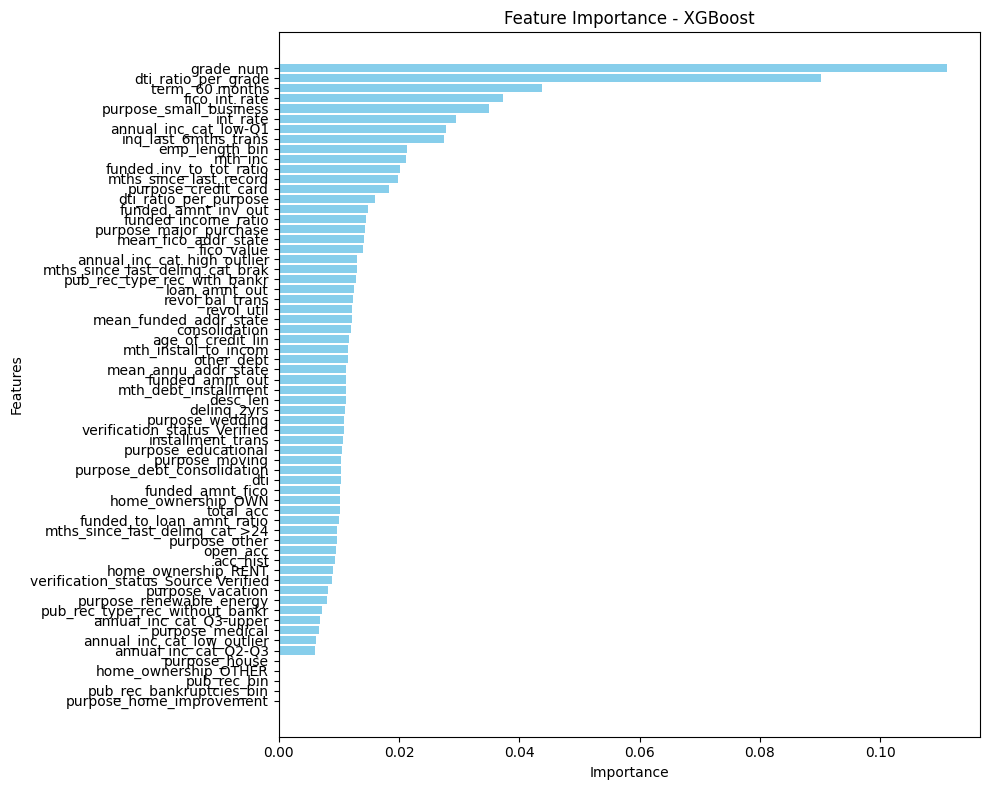

In [210]:
model = xgb.XGBClassifier(random_state=1,
    colsample_bytree=0.6,
    subsample=0.6,
    gamma=0.5,
    learning_rate=0.2,
    max_depth=3,
    min_child_weight=5,
    n_estimators=200,
    scale_pos_weight=scale_pos_weight)

model.fit(X_train, y_train)

feature_importance = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("Ranking istotnych cech:")
print(importance_df)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Model przyjął jako najistotniejsze cechy zmienne które bazują na fico i dti a nie te zmienne. Zmienne fico i dti są istotne z punktu widzenia biznesowgo więc dobrze że je pośrednio uwzględnia, szkoda że nie bazuje na nich. Jednak zmienna dti dla tego zbioru danych nie wykazywała korelacji ze stosunkiem niespłaconych do spłaconych kredytów, co jest też dość nieoczekiwane.

In [211]:
# Sprawdzenie najbardziej istotnych cech dla modelu
model_lr = LogisticRegression(solver='saga', C=0.1, max_iter=100, penalty='l2', class_weight=weights)
model_lr.fit(X_train, y_train)

coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model_lr.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)


                                Feature  Coefficient
27                        fico_int_rate     0.280392
42                  purpose_credit_card     0.272146
22                              mth_inc     0.190191
47               purpose_major_purchase     0.186639
17                       emp_length_bin     0.185736
2                   funded_amnt_inv_out     0.184949
4                     installment_trans     0.155568
30                dti_ratio_per_purpose     0.112231
33                 mean_fico_addr_state     0.108839
35                        consolidation     0.105011
56              annual_inc_cat_Q3-upper     0.096326
54                      purpose_wedding     0.096280
15                           fico_value     0.096140
55                 annual_inc_cat_Q2-Q3     0.075919
38                   home_ownership_OWN     0.068678
25                           other_debt     0.068276
60       mths_since_last_delinq_cat_>24     0.051782
45             purpose_home_improvement     0.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model regresji logistycznej nieco inaczej dobrał istotność cech, podobnie jak XBGC bazuje na zmiennej skorelowanej z fico ale również wysoko uwzglednia zmienne które wykazywały korelację ze stosunkiem niespłaconych do spłąconych kredytów takimi jak cel kredytu i okres zatrudnienia

#### <a name = '5571'></a> 5.5.7.1 Współkorelacja

In [212]:
# Macierz korelacji
num = data_row[col_new_3].select_dtypes(include=[np.number]).columns.tolist()
corr = data_row[col_new_3][num].corr()
np.fill_diagonal(corr.values, 0)
corr = corr[corr.abs() > 0.8]
corr.dropna(axis=0, how='all', inplace=True)
corr.dropna(axis=1, how='all', inplace=True)

In [213]:
corr

,loan_amnt_out,funded_amnt_out,funded_amnt_inv_out,int_rate,installment_trans,grade_num,funded_income_ratio,mth_install_to_incom,fico_int_rate,funded_amnt_fico,dti_ratio_per_grade
loan_amnt_out,NaN,0.982925,0.927440,NaN,0.913470,NaN,NaN,NaN,NaN,0.974743,NaN
funded_amnt_out,0.982925,NaN,0.943783,NaN,0.932225,NaN,NaN,NaN,NaN,0.993540,NaN
funded_amnt_inv_out,0.927440,0.943783,NaN,NaN,0.869572,NaN,NaN,NaN,NaN,0.934181,NaN
int_rate,NaN,NaN,NaN,NaN,NaN,0.938917,NaN,NaN,-0.925587,NaN,0.908735
installment_trans,0.913470,0.932225,0.869572,NaN,NaN,NaN,NaN,NaN,NaN,0.927486,NaN
grade_num,NaN,NaN,NaN,0.938917,NaN,NaN,NaN,NaN,-0.822443,NaN,0.900870
funded_income_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.953118,NaN,NaN,NaN
mth_install_to_incom,NaN,NaN,NaN,NaN,NaN,NaN,0.953118,NaN,NaN,NaN,NaN
fico_int_rate,NaN,NaN,NaN,-0.925587,NaN,-0.822443,NaN,NaN,NaN,NaN,-0.912739
funded_amnt_fico,0.974743,0.993540,0.934181,NaN,0.927486,NaN,NaN,NaN,NaN,NaN,NaN


In [214]:
#Lista zmiennych współkorelujących
corr_col = ['dti_ratio_per_grade', 'fico_int_rate', 'funded_amnt_fico', 'installment_trans', 'mth_install_to_incom', 'grade_num', 'funded_amnt_inv_out', 'funded_amnt_out']

In [215]:
X_train_filtred = X_train.drop(columns=corr_col, axis = 1)
X_test_filtred = X_test.drop(columns=corr_col, axis =1)

In [216]:
# Trenowanie modelu bez zmiennych współkorelującyh
model= xgb.XGBClassifier(random_state=1,
    colsample_bytree=0.6,
    subsample=0.6,
    gamma=0.5,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=5,
    n_estimators=200,
    scale_pos_weight=scale_pos_weight)
modelowanie(model, X_train_filtred, y_train, X_test_filtred, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.25      0.66      0.36      1328
           1       0.91      0.63      0.74      7179

    accuracy                           0.63      8507
   macro avg       0.58      0.65      0.55      8507
weighted avg       0.81      0.63      0.68      8507

ROC AUC (klasa 1): 0.70

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.24      0.68      0.36      5103
           1       0.92      0.63      0.75     28921

    accuracy                           0.64     34024
   macro avg       0.58      0.65      0.55     34024
weighted avg       0.82      0.64      0.69     34024

ROC AUC (klasa 1): 0.71


Usunięcie kolumn współkorelujących nie poprawiło predykcji.

#### <a name = '5572'></a> 5.5.7.2 Rekurencyjna eliminacja cech

#### <a name = '55721'></a> 5.5.7.2.1 Model XGBC

In [217]:
model =xgb.XGBClassifier(random_state=1,
    colsample_bytree=0.6,
    subsample=0.6,
    gamma=0.5,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=5,
    n_estimators=200,
    scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

rfe = RFE(estimator=model, n_features_to_select=20)

rfe.fit(X_train, y_train)

print("Najważniejsze cechy według RFE:")
for i, feature in enumerate(X_train.columns):
    print(f"{feature}: {'Istotna' if rfe.support_[i] else 'Nieistotna'}")

X_train_rfe = X_train.loc[:, rfe.support_]
X_test_rfe = X_test.loc[:, rfe.support_]

Najważniejsze cechy według RFE:
loan_amnt_out: Nieistotna
funded_amnt_out: Nieistotna
funded_amnt_inv_out: Istotna
int_rate: Istotna
installment_trans: Istotna
grade_num: Istotna
dti: Nieistotna
delinq_2yrs: Nieistotna
inq_last_6mths_trans: Istotna
open_acc: Nieistotna
pub_rec_bin: Nieistotna
revol_bal_trans: Nieistotna
revol_util: Istotna
total_acc: Nieistotna
pub_rec_bankruptcies_bin: Nieistotna
fico_value: Istotna
mths_since_last_record: Istotna
emp_length_bin: Istotna
funded_to_loan_amnt_ratio: Nieistotna
funded_income_ratio: Istotna
age_of_credit_lin: Nieistotna
funded_inv_to_tot_ratio: Istotna
mth_inc: Istotna
mth_install_to_incom: Nieistotna
acc_hist: Nieistotna
other_debt: Nieistotna
mth_debt_installment: Nieistotna
fico_int_rate: Istotna
funded_amnt_fico: Nieistotna
dti_ratio_per_grade: Istotna
dti_ratio_per_purpose: Istotna
mean_funded_addr_state: Nieistotna
mean_annu_addr_state: Nieistotna
mean_fico_addr_state: Nieistotna
desc_len: Nieistotna
consolidation: Nieistotna
term_ 

In [218]:
imp = X_train_rfe.columns.tolist()

In [219]:
imp

['funded_amnt_inv_out',
 'int_rate',
 'installment_trans',
 'grade_num',
 'inq_last_6mths_trans',
 'revol_util',
 'fico_value',
 'mths_since_last_record',
 'emp_length_bin',
 'funded_income_ratio',
 'funded_inv_to_tot_ratio',
 'mth_inc',
 'fico_int_rate',
 'dti_ratio_per_grade',
 'dti_ratio_per_purpose',
 'term_ 60 months',
 'purpose_small_business',
 'annual_inc_cat_Q3-upper',
 'annual_inc_cat_low-Q1',
 'pub_rec_type_rec_with_bankr']

In [220]:
# Trenowanie modelu na 20 najbardziej istotnych cechach
model =xgb.XGBClassifier(random_state=1,
    colsample_bytree=0.6,
    subsample=0.6,
    gamma=0.5,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=5,
    n_estimators=200,
    scale_pos_weight=scale_pos_weight)
modelowanie(model, X_train_rfe, y_train, X_test_rfe, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.24      0.66      0.36      1328
           1       0.91      0.62      0.74      7179

    accuracy                           0.63      8507
   macro avg       0.58      0.64      0.55      8507
weighted avg       0.80      0.63      0.68      8507

ROC AUC (klasa 1): 0.69

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.24      0.68      0.35      5103
           1       0.92      0.62      0.74     28921

    accuracy                           0.63     34024
   macro avg       0.58      0.65      0.55     34024
weighted avg       0.81      0.63      0.68     34024

ROC AUC (klasa 1): 0.71


Brak poprawy po wybraniu najistotniejszych cech.

In [221]:
#Eliminacja współkorelujacych cech wśród najbardziej istotnych zmiennych
imp_corr = data[imp].corr()
np.fill_diagonal(imp_corr.values, 0)
imp_corr = imp_corr[corr.abs() > 0.8]
imp_corr.dropna(axis=0, how='all', inplace=True)
imp_corr.dropna(axis=1, how='all', inplace=True)

In [222]:
imp_corr

,funded_amnt_inv_out,int_rate,installment_trans,grade_num,fico_int_rate,dti_ratio_per_grade
funded_amnt_inv_out,NaN,NaN,0.869572,NaN,NaN,NaN
int_rate,NaN,NaN,NaN,0.938917,-0.925587,0.908735
installment_trans,0.869572,NaN,NaN,NaN,NaN,NaN
grade_num,NaN,0.938917,NaN,NaN,-0.822443,0.900870
fico_int_rate,NaN,-0.925587,NaN,-0.822443,NaN,-0.912739
dti_ratio_per_grade,NaN,0.908735,NaN,0.900870,-0.912739,NaN


In [223]:
imp_del = ['grade_num', 'dti_ratio_per_grade', 'installment_trans',  'fico_int_rate']
X_train_rfe_d = X_train_rfe.drop(columns=imp_del, axis = 1)
X_test_rfe_d = X_test_rfe.drop(columns=imp_del, axis = 1)

In [224]:
# Trenowanie modelu z wykorzystaniem naistotnejszych zmiennych bez zmiennych współkorelujących
model =xgb.XGBClassifier(random_state=1,
    colsample_bytree=0.6,
    subsample=0.6,
    gamma=0.5,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=5,
    n_estimators=200,
    scale_pos_weight=scale_pos_weight)
modelowanie(model, X_train_rfe_d, y_train, X_test_rfe_d, y_test)


=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.25      0.66      0.36      1328
           1       0.91      0.63      0.75      7179

    accuracy                           0.64      8507
   macro avg       0.58      0.65      0.56      8507
weighted avg       0.81      0.64      0.69      8507

ROC AUC (klasa 1): 0.70

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.24      0.68      0.36      5103
           1       0.92      0.63      0.75     28921

    accuracy                           0.64     34024
   macro avg       0.58      0.65      0.55     34024
weighted avg       0.82      0.64      0.69     34024

ROC AUC (klasa 1): 0.71


In [225]:
# Sprawdzenie istotności cech takiego modelu
model = xgb.XGBClassifier(random_state=1,
    colsample_bytree=0.6,
    subsample=0.6,
    gamma=0.5,
    learning_rate=0.2,
    max_depth=3,
    min_child_weight=5,
    n_estimators=200,
    scale_pos_weight=scale_pos_weight)

model.fit(X_train_rfe_d, y_train)

feature_importance = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_rfe_d.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("Ranking istotnych cech:")
print(importance_df)

Ranking istotnych cech:
                        Feature  Importance
11              term_ 60 months    0.180945
12       purpose_small_business    0.126238
2          inq_last_6mths_trans    0.083772
1                      int_rate    0.075418
4                    fico_value    0.068440
6                emp_length_bin    0.062825
8       funded_inv_to_tot_ratio    0.046945
5        mths_since_last_record    0.045022
14        annual_inc_cat_low-Q1    0.041152
9                       mth_inc    0.040645
10        dti_ratio_per_purpose    0.039274
3                    revol_util    0.038985
7           funded_income_ratio    0.038624
15  pub_rec_type_rec_with_bankr    0.038139
13      annual_inc_cat_Q3-upper    0.038125
0           funded_amnt_inv_out    0.035451


#### <a name = '55722'></a> 5.5.7.2.2 Model LogisticRegression

In [226]:
model_lr = LogisticRegression(solver='saga', C=0.1, max_iter=100, penalty='l2', class_weight=weights)
model.fit(X_train, y_train)

rfe = RFE(estimator=model, n_features_to_select=20)

rfe.fit(X_train, y_train)

print("Najważniejsze cechy według RFE:")
for i, feature in enumerate(X_train.columns):
    print(f"{feature}: {'Istotna' if rfe.support_[i] else 'Nieistotna'}")

X_train_rfe = X_train.loc[:, rfe.support_]
X_test_rfe = X_test.loc[:, rfe.support_]

Najważniejsze cechy według RFE:
loan_amnt_out: Nieistotna
funded_amnt_out: Nieistotna
funded_amnt_inv_out: Istotna
int_rate: Istotna
installment_trans: Istotna
grade_num: Istotna
dti: Nieistotna
delinq_2yrs: Nieistotna
inq_last_6mths_trans: Istotna
open_acc: Nieistotna
pub_rec_bin: Nieistotna
revol_bal_trans: Istotna
revol_util: Istotna
total_acc: Nieistotna
pub_rec_bankruptcies_bin: Nieistotna
fico_value: Istotna
mths_since_last_record: Istotna
emp_length_bin: Istotna
funded_to_loan_amnt_ratio: Nieistotna
funded_income_ratio: Istotna
age_of_credit_lin: Nieistotna
funded_inv_to_tot_ratio: Istotna
mth_inc: Istotna
mth_install_to_incom: Nieistotna
acc_hist: Nieistotna
other_debt: Nieistotna
mth_debt_installment: Nieistotna
fico_int_rate: Istotna
funded_amnt_fico: Nieistotna
dti_ratio_per_grade: Nieistotna
dti_ratio_per_purpose: Istotna
mean_funded_addr_state: Istotna
mean_annu_addr_state: Nieistotna
mean_fico_addr_state: Istotna
desc_len: Nieistotna
consolidation: Nieistotna
term_ 60 mon

In [227]:
imp = X_train_rfe.columns.tolist()

In [228]:
imp

['funded_amnt_inv_out',
 'int_rate',
 'installment_trans',
 'grade_num',
 'inq_last_6mths_trans',
 'revol_bal_trans',
 'revol_util',
 'fico_value',
 'mths_since_last_record',
 'emp_length_bin',
 'funded_income_ratio',
 'funded_inv_to_tot_ratio',
 'mth_inc',
 'fico_int_rate',
 'dti_ratio_per_purpose',
 'mean_funded_addr_state',
 'mean_fico_addr_state',
 'term_ 60 months',
 'purpose_small_business',
 'purpose_wedding']

Niezaleznie od modelu te same zmienne zostały wytypowane jako istotne

In [229]:
# Trenowanie modelu na 20 najbardziej istotnych cechach
model_lr = LogisticRegression(solver='saga', C=0.1, max_iter=100, penalty='l2', class_weight=weights)
modelowanie(model, X_train_rfe, y_train, X_test_rfe, y_test)

=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.26      0.63      0.36      1328
           1       0.91      0.66      0.77      7179

    accuracy                           0.66      8507
   macro avg       0.58      0.65      0.57      8507
weighted avg       0.80      0.66      0.70      8507

ROC AUC (klasa 1): 0.70

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.29      0.72      0.41      5103
           1       0.93      0.68      0.79     28921

    accuracy                           0.69     34024
   macro avg       0.61      0.70      0.60     34024
weighted avg       0.84      0.69      0.73     34024

ROC AUC (klasa 1): 0.77


Brak poprawy po wybraniu najistotniejszych cech.

In [230]:
#Eliminacja współkorelujacych cech wśród najbardziej istotnych zmiennych
imp_corr = data[imp].corr()
np.fill_diagonal(imp_corr.values, 0)
imp_corr = imp_corr[corr.abs() > 0.8]
imp_corr.dropna(axis=0, how='all', inplace=True)
imp_corr.dropna(axis=1, how='all', inplace=True)

In [231]:
imp_corr

,funded_amnt_inv_out,int_rate,installment_trans,grade_num,fico_int_rate
funded_amnt_inv_out,NaN,NaN,0.869572,NaN,NaN
int_rate,NaN,NaN,NaN,0.938917,-0.925587
installment_trans,0.869572,NaN,NaN,NaN,NaN
grade_num,NaN,0.938917,NaN,NaN,-0.822443
fico_int_rate,NaN,-0.925587,NaN,-0.822443,NaN


In [232]:
imp_del = ['grade_num', 'installment_trans',  'fico_int_rate']
X_train_rfe_d = X_train_rfe.drop(columns=imp_del, axis = 1)
X_test_rfe_d = X_test_rfe.drop(columns=imp_del, axis = 1)

In [233]:
# Trenowanie modelu z wykorzystaniem najistotnejszych zmiennych bez zmiennych współkorelujących
model_lr = LogisticRegression(solver='saga', C=0.1, max_iter=100, penalty='l2', class_weight=weights)
modelowanie(model, X_train_rfe_d, y_train, X_test_rfe_d, y_test)


=== ZBIÓR TESTOWY ===
              precision    recall  f1-score   support

           0       0.26      0.62      0.36      1328
           1       0.91      0.67      0.77      7179

    accuracy                           0.66      8507
   macro avg       0.58      0.65      0.57      8507
weighted avg       0.80      0.66      0.71      8507

ROC AUC (klasa 1): 0.71

=== ZBIÓR TRENINGOWY ===
              precision    recall  f1-score   support

           0       0.29      0.72      0.41      5103
           1       0.93      0.68      0.79     28921

    accuracy                           0.69     34024
   macro avg       0.61      0.70      0.60     34024
weighted avg       0.84      0.69      0.73     34024

ROC AUC (klasa 1): 0.77


In [234]:
# Sprawdzenie istotności cech takiego modelu
model_lr = LogisticRegression(solver='saga', C=0.1, max_iter=100, penalty='l2', class_weight=weights)
model_lr.fit(X_train_rfe_d, y_train)

coefficients = pd.DataFrame({
    'Feature': X_train_rfe_d.columns,
    'Coefficient': model_lr.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)



                    Feature  Coefficient
10                  mth_inc     0.240938
7            emp_length_bin     0.214318
11    dti_ratio_per_purpose     0.182093
0       funded_amnt_inv_out     0.164792
13     mean_fico_addr_state     0.111919
5                fico_value     0.109134
16          purpose_wedding     0.097721
12   mean_funded_addr_state     0.014001
9   funded_inv_to_tot_ratio     0.012913
6    mths_since_last_record     0.000962
3           revol_bal_trans    -0.050270
4                revol_util    -0.172832
8       funded_income_ratio    -0.230672
2      inq_last_6mths_trans    -0.392562
15   purpose_small_business    -0.403217
14          term_ 60 months    -0.514340
1                  int_rate    -0.541215


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Wybór najistotniejszych cech dla modelu nie przyniósł poprawy w predykcji

#### <a name = '558'></a> 5.5.8 Zmiana progu kwalifikacji

In [235]:
model = xgb.XGBClassifier(random_state=1,
    colsample_bytree=0.6,
    subsample=0.6,
    gamma=0.5,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=5,
    n_estimators=200,
    scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")

threshold = 0.6
y_pred_new = (y_prob >= threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_new))
print(classification_report(y_test, y_pred_new))


ROC AUC: 0.6942
[[1158  170]
 [4751 2428]]
              precision    recall  f1-score   support

           0       0.20      0.87      0.32      1328
           1       0.93      0.34      0.50      7179

    accuracy                           0.42      8507
   macro avg       0.57      0.61      0.41      8507
weighted avg       0.82      0.42      0.47      8507



Zmiana progu kwalifikacji wpływa na zmianę metryk targetów  czy

#### <a name = '56'></a> 5.6 Podsumowanie

Oba modele:  
LogisticRegression(solver='saga', C=0.1, max_iter=100, penalty='l2', class_weight=weights)  
xgb.XGBClassifier(random_state=1, colsample_bytree=0.6, subsample=0.6, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=200, scale_pos_weight=scale_pos_weight)   


 - dają zbliżone wartości predykcji i takie same wartości ROC AUC,  
   
 - różnią się w wynikach kroswalidacji na nieznaczna korzyść XGBC.  
   
 - pomimo optymalizacji hiperparametrów learning_curve dla obu modeli był zły choć miał kompletnie różny charakter. Dla modelu regresji logistycznej obie krzywe training score i cross-validation score miały niskie wartości i od razu się pokrywały co oznacza że model nie poprawia się wraz z większą liczbą danych, a jego złożoność jest prawdopodobnie za niska, by dobrze uchwycił zalezności danych. Dla modelu XGBC krzywe training score i cross-validation score zbiegały się lecz pozostała między nimi luka co wskazuje na lekkie przeuczenie, ale różnica między liniami zmniejsza się wraz ze wzrostem liczby danych, sugerując, że być może dodanie większej ilości danych mogłoby poprawić wyniki modelu.  
      
 - model regresji logistycznej lepiej przewidywał target 0 model XGBC lepiej target 1.  
  
 - pomimo optymalizacji hiperparametrów, sprawdzenia różnych kombinacji zmiennych oraz zastosowania oversamplingu i PCA nie udało sie otrzymać wartości ROC AUC wyższej niż 0.7
